In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math
import pylab as P
import tensorflow as tf

data = pd.read_csv('data/train.csv')

print(data.describe(include = 'all'))

print(data.dtypes)

print(data.info())

        PassengerId    Survived      Pclass                       Name   Sex  \
count    891.000000  891.000000  891.000000                        891   891   
unique          NaN         NaN         NaN                        891     2   
top             NaN         NaN         NaN  Van Impe, Miss. Catharina  male   
freq            NaN         NaN         NaN                          1   577   
mean     446.000000    0.383838    2.308642                        NaN   NaN   
std      257.353842    0.486592    0.836071                        NaN   NaN   
min        1.000000    0.000000    1.000000                        NaN   NaN   
25%      223.500000    0.000000    2.000000                        NaN   NaN   
50%      446.000000    0.000000    3.000000                        NaN   NaN   
75%      668.500000    1.000000    3.000000                        NaN   NaN   
max      891.000000    1.000000    3.000000                        NaN   NaN   

               Age       SibSp       Pa

In [39]:

def slice_by_survived(f):
    survived_feature = data['Survived']
    alive = data[(survived_feature == 1) & (f.isnull() == False)][feature]
    dead = data[(survived_feature == 0) & (f.isnull() == False)][feature]

    return np.array(alive, dtype='float'), np.array(dead, dtype='float')
    
numerical_features = [
    ['Age'],
    ['Fare'],
    ['Parch'],
    ['SibSp'],
]
    
for features in numerical_features:
    f = None
    for feature in features:
        if f is None:
            f = data[feature]
        else:
            f *= data[feature]
    alive, dead = slice_by_survived(f)
    plt.figure()
    plt.title('X'.join(features))
    plt.bar([0, 1], [alive.mean(), dead.mean()], color=['blue', 'red'])
    plt.figure()

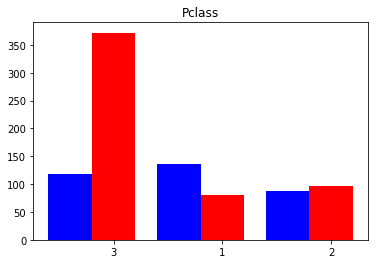

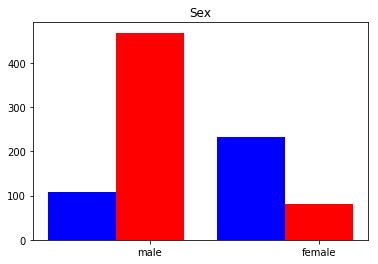

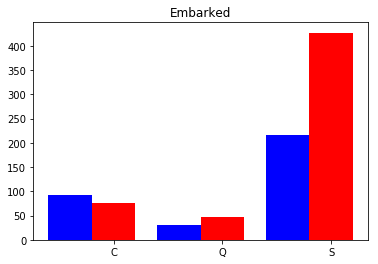

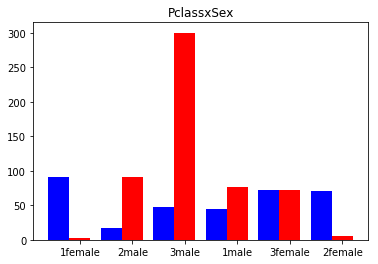

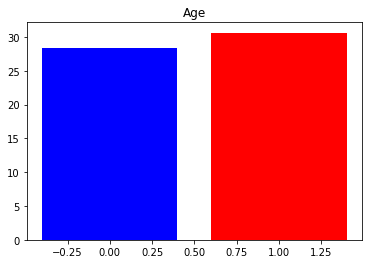

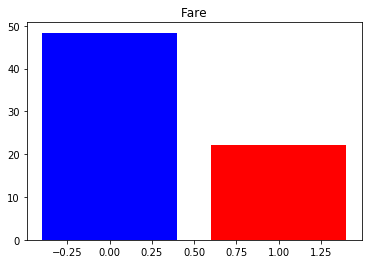

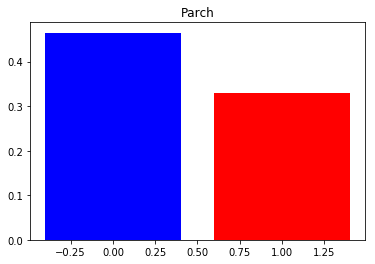

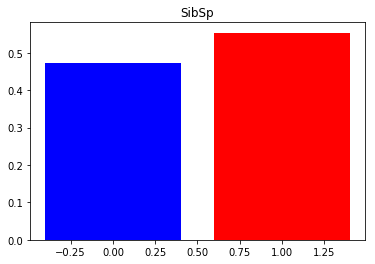

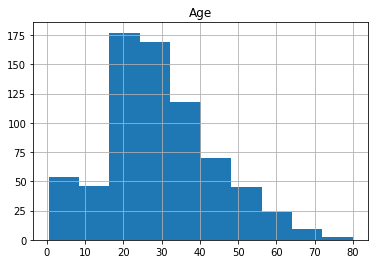

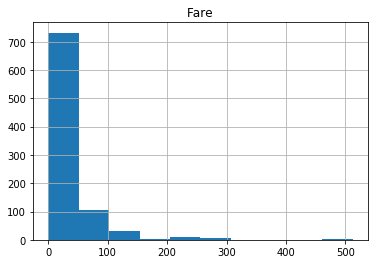

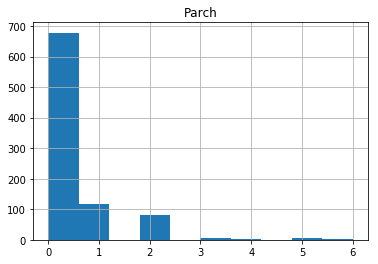

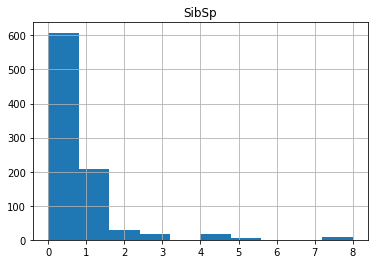

In [40]:
for feature in numerical_features:
    data[feature].hist()
    P.show()

In [41]:
def CrossFeature(features):
    f = None
    d = data[features + ['Survived']].dropna()
    out = pd.DataFrame()
    for feature in features:
        s = pd.Series(str(x) for x in data[feature])
        if f is None:
            f = s
        else:
            f += s
    name = 'X'.join(features)
    out['Survived'] = d['Survived']
    out[name] = f
    return out[name], out['Survived']

categorical_features = [
    ['Pclass'],
    ['Sex'],
    ['Embarked'],
    ['Pclass', 'Sex'],
]

for features in categorical_features:
    print(features)
    f, surv = CrossFeature(features)
    classes = list(x for x in set(f) if type(x) != float or not math.isnan(x))
    distribution = [(f == c).sum() for c in classes]
    outcome = [(len(f[(f == c) & (surv == 1)]),
                len(f[(f == c) & (surv == 0)])) for c in classes]
    positions = []
    label_positions = []
    offset = 0
    heights = []
    color = []
    for out in outcome:
        positions.append(0.2 + offset)
        positions.append(1.0 + offset)
        color += ['b', 'r']
        heights.extend(out)
        label_positions.append(1 + offset)
        offset += 2
    
    fig, ax = plt.subplots()
    ax.set_title('x'.join(features))
    rects = ax.bar(positions, heights, color=color)
    ax.set_xticks(label_positions)
    ax.set_xticklabels(classes)

['Pclass']
['Sex']
['Embarked']
['Pclass', 'Sex']


In [42]:
# Prepare Age feature
def PrepareAge(data):
    age = data['Age'].copy()
    mean_age = age.mean()
    print('Mean age: {}'.format(mean_age))
    age[age.isnull()] = mean_age
    return age

# Prepare categorical feature
def PrepareCat(data, feature):
    f = data[feature]
    classes = sorted(x for x in set(f) if type(x) != float or not math.isnan(x))
    print(classes)
    if len(classes) <= 2:
        out = pd.DataFrame({feature:(f == classes[0]).map({True:1, False:0})})
        return out
    ones = np.ones(len(f))
    out = pd.DataFrame({('{}_{}'.format(feature, c)):(f == c).map({True:1, False:0}) for c in classes})
    return out

def Merge(d1, d2):
    output = pd.DataFrame()
    for f in d1:
        output[f] = d1[f].copy()
    for f in d2:
        output[f] = d2[f].copy()
    return output
      

print(PrepareCat(data, 'Embarked').describe())

['C', 'Q', 'S']
       Embarked_C  Embarked_Q  Embarked_S
count  891.000000  891.000000  891.000000
mean     0.188552    0.086420    0.722783
std      0.391372    0.281141    0.447876
min      0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000
50%      0.000000    0.000000    1.000000
75%      0.000000    0.000000    1.000000
max      1.000000    1.000000    1.000000


In [43]:
def CrossCat(data, features):
    name = '*'.join(features)
    p = None
    for f in features:
        s = pd.Series(str(x) for x in data[f])
        p = s if p is None else (p + '*' + s)
        p[data[f].isnull()] = math.nan
    out = pd.DataFrame()
    out[name] = p
    return PrepareCat(out, name)

def PrepareFeatures(data):
    output = pd.DataFrame()
    output['Age'] = PrepareAge(data) / 80
    output['Fare'] = data['Fare'] / 512
    output['Parch'] = data['Parch'] / 6
    output['SibSp'] = data['SibSp'] / 8
    output = Merge(output, PrepareCat(data, 'Sex'))
    output = Merge(output, PrepareCat(data, 'Pclass'))
    output = Merge(output, PrepareCat(data, 'Embarked'))
    output['Sex_Age'] = output['Age']*output['Sex']
    output['Sex_Fare'] = output['Fare']*output['Sex']
    output = Merge(output, CrossCat(data, ['Sex', 'Embarked']))
    output = Merge(output, CrossCat(data, ['Sex', 'Pclass']))
    return output

def PrepareTarget(data):
    return np.array(data.Survived, dtype='int8').reshape(-1, 1)

training_data = PrepareFeatures(data)

target_training_data = PrepareTarget(data)

print(training_data[training_data['Age'].isnull()])

print(training_data.describe())
print(training_data.info())

training_data = np.array(training_data, dtype='float32')
print (training_data)

Mean age: 29.69911764705882
['female', 'male']
[1, 2, 3]
['C', 'Q', 'S']
['female*C', 'female*Q', 'female*S', 'male*C', 'male*Q', 'male*S']
['female*1', 'female*2', 'female*3', 'male*1', 'male*2', 'male*3']
Empty DataFrame
Columns: [Age, Fare, Parch, SibSp, Sex, Pclass_1, Pclass_2, Pclass_3, Embarked_C, Embarked_Q, Embarked_S, Sex_Age, Sex_Fare, Sex*Embarked_female*C, Sex*Embarked_female*Q, Sex*Embarked_female*S, Sex*Embarked_male*C, Sex*Embarked_male*Q, Sex*Embarked_male*S, Sex*Pclass_female*1, Sex*Pclass_female*2, Sex*Pclass_female*3, Sex*Pclass_male*1, Sex*Pclass_male*2, Sex*Pclass_male*3]
Index: []

[0 rows x 25 columns]
              Age        Fare       Parch       SibSp         Sex    Pclass_1  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.371239    0.062899    0.063599    0.065376    0.352413    0.242424   
std      0.162525    0.097057    0.134343    0.137843    0.477990    0.428790   
min      0.005250    0.000000    0.000000  

In [47]:
ITERATIONS = 40000
LEARNING_RATE = 1e-4

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)
 
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Let's train the model
feature_count = training_data.shape[1]
x = tf.placeholder('float', shape=[None, feature_count], name='x')
y_ = tf.placeholder('float', shape=[None, 1], name='y_')

print(x.get_shape())

nodes = 20

w1 = weight_variable([feature_count, nodes])
b1 = bias_variable([nodes])
l1 = tf.nn.relu(tf.matmul(x, w1) + b1)

w2 = weight_variable([nodes, 1])
b2 = bias_variable([1])
y = tf.nn.sigmoid(tf.matmul(l1, w2) + b2)

cross_entropy = -tf.reduce_mean(y_*tf.log(tf.maximum(0.00001, y)) + (1.0 - y_)*tf.log(tf.maximum(0.00001, 1.0-y)))
reg = 0.01 * (tf.reduce_mean(tf.square(w1)) + tf.reduce_mean(tf.square(w2)))

predict = (y > 0.5)

correct_prediction = tf.equal(predict, (y_ > 0.5))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
                              
                              
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy + reg)

init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

print(training_data.dtype)
for i in range(ITERATIONS):
    feed={x:training_data, y_:target_training_data}
    sess.run(train_step, feed_dict=feed)
    if i % 1000 == 0 or i == ITERATIONS-1:
        print('{} {} {:.2f}%'.format(i, sess.run(cross_entropy, feed_dict=feed), sess.run(accuracy, feed_dict=feed)*100.0))
        

(?, 25)
float32
0 0.7064142823219299 37.15%
1000 0.48172715306282043 81.26%
2000 0.43519946932792664 81.26%
3000 0.4247548282146454 81.14%
4000 0.4189319908618927 81.37%
5000 0.41467151045799255 81.26%
6000 0.4113270044326782 81.48%
7000 0.40869268774986267 81.71%
8000 0.40633076429367065 82.04%
9000 0.4040820896625519 82.15%
10000 0.40190064907073975 82.27%
11000 0.3997734785079956 82.27%
12000 0.3977365791797638 82.15%
13000 0.39568546414375305 82.60%
14000 0.3940693438053131 83.05%
15000 0.39244142174720764 83.05%
16000 0.38978755474090576 83.50%
17000 0.3876577615737915 83.16%
18000 0.3860219717025757 83.28%
19000 0.3842771053314209 83.84%
20000 0.38238126039505005 83.61%
21000 0.38033413887023926 83.61%
22000 0.3787761926651001 83.61%
23000 0.37725797295570374 83.73%
24000 0.37603843212127686 84.06%
25000 0.3751138746738434 84.06%
26000 0.3741675913333893 84.18%
27000 0.37328875064849854 84.18%
28000 0.3713161051273346 84.51%
29000 0.3699801564216614 84.85%
30000 0.368933707475662

In [45]:
test_data = pd.read_csv('data/test.csv')

print(test_data.describe(include='all'))

test_features = PrepareFeatures(test_data)

print(test_features)

predicted = sess.run(predict, feed_dict={x:test_features})

sess.close()
# Write data

sol = pd.DataFrame()
sol['PassengerId'] = test_data['PassengerId']
sol['Survived'] = pd.Series(predicted.reshape(-1)).map({True:1, False:0})
print(sol)
sol.to_csv('solution3.csv', index=False)

        PassengerId      Pclass                      Name   Sex         Age  \
count    418.000000  418.000000                       418   418  332.000000   
unique          NaN         NaN                       418     2         NaN   
top             NaN         NaN  Dyker, Mr. Adolf Fredrik  male         NaN   
freq            NaN         NaN                         1   266         NaN   
mean    1100.500000    2.265550                       NaN   NaN   30.272590   
std      120.810458    0.841838                       NaN   NaN   14.181209   
min      892.000000    1.000000                       NaN   NaN    0.170000   
25%      996.250000    1.000000                       NaN   NaN   21.000000   
50%     1100.500000    3.000000                       NaN   NaN   27.000000   
75%     1204.750000    3.000000                       NaN   NaN   39.000000   
max     1309.000000    3.000000                       NaN   NaN   76.000000   

             SibSp       Parch    Ticket        Far

In [46]:
train_df = pd.read_csv('feature.csv')
test_df = pd.read_csv('test.csv')
train_df_array = np.array(train_df, dtype='float32')
test_df_array = np.array(test_df, dtype='float32')

feed_x = train_df_array[:, 1:].astype('float32')
feed_y = train_df_array[:, 0].reshape(-1, 1).astype('float32')

feed1 = {x: feed_x, y: feed_y}
for i in range(ITERATIONS):
    feed={x:training_data, y_:target_training_data}
    sess.run(train_step, feed_dict=feed1)
    if i % 1000 == 0 or i == ITERATIONS-1:
        print('{} {} {:.2f}%'.format(i, sess.run(cross_entropy, feed_dict=feed), sess.run(accuracy, feed_dict=feed1)*100.0))
        

RuntimeError: Attempted to use a closed Session.